# Tutorial 03: overview of **implant** stages

Every experiment will have a stage where a patch or patches are implanted in a target image.

Most of the implanting tools in `electricmayhem` input a pandas `DataFrame` object that gives the top, bottom, left, and right pixel values for a region for each patch in each target image. In multi-patch experiments it expects each patch to appear in each image.

The `em.WarpPatchImplanter()` class works a bit differently- it inputs a `DataFrame` that gives x and y coordinates of where each corner of the patch should go in the target image, and differentiably distorts, rescales, and rotates the patch to fit. It can handle datasets where not every patch is in every image, as well as implanting the same image multiple times in the same target. This flexibility comes at the cost of some overheard, however, and varying numbers of patches per target can cause the memory footprint to vary during training. Use with caution!!

When building dataframes for either type of implanter:

* To build a multi-patch dataset, include a "patch" column specifying which patch goes in which box.
* A "split" column that can take values "train" or "eval" will tell the implanter which target images to use during training and evaluation. If you leave this column out it will use the same images for each. I would advise against it though.
* A hash digest of the dataframe will get logged to MLflow, so you'll be able to identify which runs are associated with which version of your labels. An optional `dataset_name` kwarg can make it much easier to interpret the logs.

All implanters in `electricmayhem` can handle masked and translucent patches by specifying a `mask` argument. Pass a float between 0 and 1 to make the patch semitransparent or an image (with same dimensions as the patch) to use as a mask. In the multi-patch case use a dictionary to specify a float or mask for each patch separately. These masks and alpha values are fixed; I don't currently have a capability to do mask learning.

In [1]:
import pandas as pd
from PIL import Image
import electricmayhem.whitebox as em

[WARNING 11-12 20:25:28] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


Load a test image and a test mask...

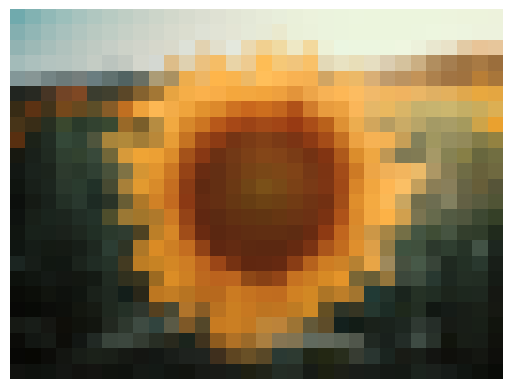

In [2]:
#flower = em.load_to_tensor(Image.open("data/flower2.png").resize((128,92)))
flower = em.load_to_tensor(Image.open("data/flower2.png").resize((32,24)))
em.plot(flower)

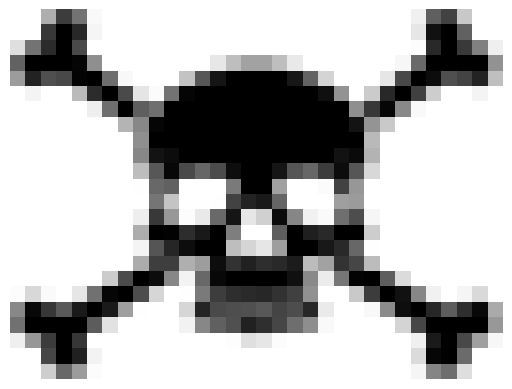

In [3]:
mask = em.load_to_tensor(Image.open("data/masks/jolly_roger.png").resize((32,24)))
em.plot(mask)

## Rectangle Implanters

There are currently three versions implemented, for slightly different applications

* `em.ScaleToBoxRectanglePatchImplanter` resizes each patch to the label box
* `em.FixedRatioRectanglePatchImplanter` resizes each patch to a fixed fraction of the dimensions of the label box and implants randomly within the box
* `em.RectanglePatchImplanter` resizes each patch by a random scale **not** determined by the box before implanting

We'll use `em.ScaleToBoxRectanglePatchImplanter` here but the API is pretty similar for all of them.

In [4]:
df_rect = pd.read_csv("data/toycar/toycar_rect_dataset.csv")
len(df_rect)

14

In [5]:
df_rect.head()

,patch,image,split,xmin,xmax,ymin,ymax
0,hood,data/toycar/near_nadir_arc/080.png,train,380,443,295,327
1,roof,data/toycar/near_nadir_arc/080.png,train,387,434,241,264
2,roof,data/toycar/near_nadir_arc/090.png,eval,356,408,238,258
3,hood,data/toycar/near_nadir_arc/090.png,eval,359,417,283,319
4,hood,data/toycar/near_nadir_arc/063.png,train,390,454,283,315


In [6]:
imp = em.ScaleToBoxRectanglePatchImplanter(df_rect, dataset_name="toycar_rect_no_ground")

All of the implanters have a `plot_boxes()` method you can use for a quick visual check on your labels:

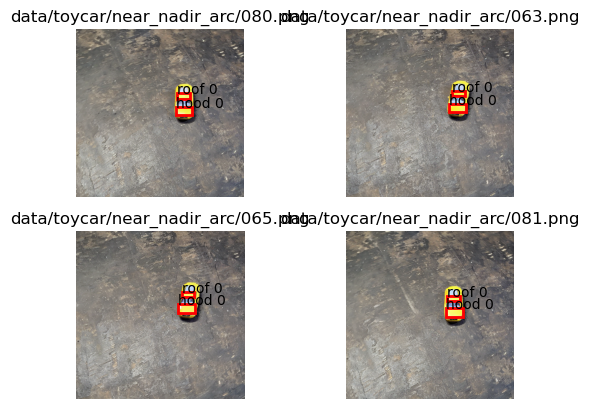

In [7]:
imp.plot_boxes();

Now let's make a batch of patches, pass through the implanter and visualize the outputs:

In [8]:
patch_batch = {k:flower.unsqueeze(0) for k in ["hood", "roof"]}
implanted, _ = imp(patch_batch)

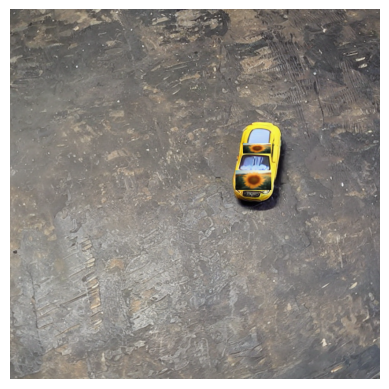

In [9]:
em.plot(implanted)

After any time we call the implanter, we can get a JSON-serializable dictionary containing all the sampled parameters using the `get_last_sample_as_dict()` method:

In [10]:
imp.get_last_sample_as_dict()

{'image': ['data/toycar/near_nadir_arc/065.png'],
 'box_hood': [0.0],
 'box_roof': [0.0]}

### Now with masking

All implanters can accept three types of inputs for masking:

* A float representing an alpha value between `0` (transparent) and `1` (opaque)
* A grayscale tensor the same dimensions as the patch
* A dictionary mapping patch names to either of the above

For example:

In [11]:
imp = em.ScaleToBoxRectanglePatchImplanter(df_rect, mask={"hood":1-mask, "roof":0.75}, dataset_name="toycar_rect_no_ground")

In [12]:
patch_batch = {k:flower.unsqueeze(0) for k in ["hood", "roof"]}
implanted, _ = imp(patch_batch)

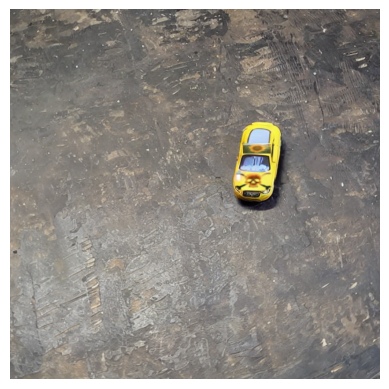

In [13]:
em.plot(implanted)

## Warp implanter

Currently only one implemented.

In [14]:
df_warp = pd.read_csv("data/toycar/toycar_warp_dataset.csv")
len(df_warp)

74

In [15]:
df_warp.head()

,image,ulx,uly,urx,ury,lrx,lry,llx,lly,patch,split
0,data/toycar/near_nadir_arc/006.png,280.0,268.0,272.0,143.0,428.0,128.0,449.0,250.0,ground,train
1,data/toycar/near_nadir_arc/006.png,454.0,296.0,474.0,313.0,454.0,331.0,435.0,314.0,hood,train
2,data/toycar/near_nadir_arc/006.png,500.0,248.0,521.0,263.0,503.0,280.0,481.0,265.0,roof,train
3,data/toycar/near_nadir_arc/013.png,281.0,276.0,261.0,157.0,410.0,133.0,442.0,248.0,ground,train
4,data/toycar/near_nadir_arc/013.png,456.0,297.0,478.0,311.0,460.0,331.0,439.0,318.0,hood,train


The constructor for `em.WarpPatchImplanter` requires you to give the dimensions for each patch- it'll use this to precompute transformation matrices for each patch/target combination. For large datasets this might take a few minutes but significantly speeds up training.

Unlike the box implanters, this one keeps the target images on the CPU and only copies them over a batch at a time. This adds a bit of overhead but makes it practical to train with large target datasets.

In [16]:
flower = em.load_to_tensor(Image.open("data/flower2.png").resize((64,48)))
mask = em.load_to_tensor(Image.open("data/masks/jolly_roger.png").resize((64,48)))

In [17]:
imp = em.WarpPatchImplanter(df_warp, 
                            patch_shapes={k:(3,48,64) for k in ["ground", "hood", "roof", "door"]},
                            mask={"ground":mask, "hood":1-mask, "roof":1, "door":1},
                            dataset_name="toycar_warp_dataset")

Note the difference in how dimensions are specified here (pytorch CHW format) versus how we resized the image with PIL (WH) above.

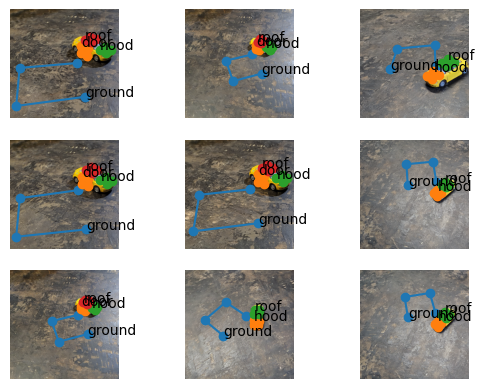

In [18]:
imp.plot_boxes()

In [19]:
patch_batch = {k:flower.unsqueeze(0) for k in ["hood", "roof", "ground", "door"]}
implanted, _ = imp(patch_batch)

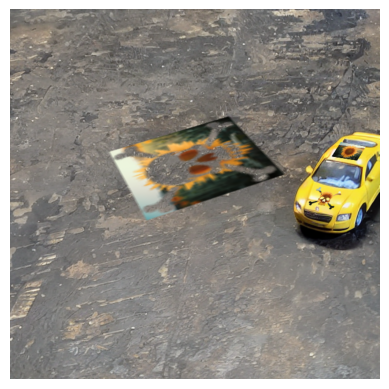

In [20]:
em.plot(implanted)